<a href="https://colab.research.google.com/github/inesbsilveira/2nd-semester-2023/blob/main/20230925_IS_MC_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip install rasterio

In [78]:
import rasterio
from rasterio.windows import Window
import os
import shutil
import numpy as np
from PIL import Image
from fastai.vision.all import *
from sklearn.metrics import classification_report, roc_auc_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tifffile as tiff
import matplotlib.image as mpimg

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
user='I' # escolher 'M' ou 'I'
N_epochs=30
target_names = ['not greenhouse', 'greenhouse']
Nrows,Ncols = 20, 8 # número de blocos a usar 20*8=160

In [81]:
# Specify the directory path
if user=='M':
  directory = '/content/drive/MyDrive/inv_proj/S2change_DGT/Estufas_Alentejo'
else:
  directory = '/content/drive/MyDrive/AAA/'

path=Path(directory)
image_folder_name = "images"
label_folder_name = "labels"
predicted_folder_name = "predicted"
image_folder = os.path.join(directory, image_folder_name)
os.makedirs(image_folder, exist_ok=True)
label_folder = os.path.join(directory, label_folder_name)
os.makedirs(label_folder, exist_ok=True)
predicted_folder = os.path.join(directory, predicted_folder_name)
os.makedirs(predicted_folder, exist_ok=True)

Functions

In [82]:
# Calculate and display unique values and their datatype in a tif file
def display_unique_values_tiff_file (input_file):
  # Open the TIFF file
  with rasterio.open(input_file, 'r') as src:
      # Read the data as a NumPy array
      tiff_array = src.read(1)  # Assuming it's a single-band TIFF

      # Find unique values in the NumPy array
      unique_values = np.unique(tiff_array)

      # Get the data type of the TIFF file
      data_type = src.dtypes[0]

  # Display the data type
  print(f"Data Type: {data_type}")

  # Display the unique values
  print("Unique Values:")
  for value in unique_values:
      print(value)

  # Print the data in the NumPy array
  print(tiff_array)

In [83]:
# Calculate and display unique values and their datatype in a PNG image
def display_unique_values_and_datatype(input_file):
    # Open the PNG image
    img = Image.open(input_file)

    # Convert the image to a NumPy array
    png_array = np.array(img)

    # Find unique values in the NumPy array
    unique_values = np.unique(png_array)

    # Get the data type of the PNG image
    data_type = png_array.dtype

    # Display the data type
    print(f"Data Type: {data_type}")

    # Display the unique values
    print("Unique Values:")
    for value in unique_values:
        print(value)

    # Print the data in the NumPy array
    print(png_array)

In [84]:
# Replace NODATA values with 0. this function requires the the value assigned to nodata values
def convert_nodata_values (nodata_value, input_file,output_file):
  # Open the input TIFF file
  with rasterio.open(input_file, 'r') as src:
      # Read the data as a NumPy array
      data = src.read(1)

      # Replace NoData values with 0
      data[data == nodata_value] = 0

      # Create a new TIFF file for writing
      with rasterio.open(
          output_file,
          'w',
          driver='GTiff',
          width=src.width,
          height=src.height,
          count=1,
          dtype=rasterio.uint8,  # Adjust data type as needed
          crs=src.crs,
          transform=src.transform,
      ) as dst:
          # Write the modified data to the new TIFF file
          dst.write(data, 1)

  print(f"NoData values converted to 0")


In [85]:
# Display a TIFF file
def display_tiff_file (input_file):
  # Load and display the TIFF image
  img = mpimg.imread(input_file)
  plt.imshow(img, cmap='gray')  # Use 'gray' colormap for binary images
  plt.axis('off')  # Turn off axis labels and ticks
  plt.show()


In [86]:
# Function to clip and rescale tif files and save png images in a folder
# Input files are tiff files with 1 or 3 bands, output_folder is the folder where the png images are going to be stored. Nrows and Ncols are defined above
def clip_raster_and_rescale(input_file, output_folder, Nrows, Ncols):
    with rasterio.open(input_file) as src:
        height = src.height // Nrows
        width = src.width // Ncols
        Nbands = src.count  # Get the number of bands in the input file

        for i in range(Nrows):
            for j in range(Ncols):
                ymin = i * height
                ymax = (i + 1) * height
                xmin = j * width
                xmax = (j + 1) * width
                window = Window.from_slices((ymin, ymax), (xmin, xmax))

                if Nbands == 1:
                    clipped_data = src.read(window=window)
                    clipped_meta = src.meta.copy()
                    clipped_meta.update({
                        'height': window.height,
                        'width': window.width,
                        'transform': src.window_transform(window)
                })
                    output_file = os.path.join(output_folder, f'image_{i}_{j}_mask.png')
                    with rasterio.open(output_file, 'w', **clipped_meta) as dst:
                        dst.write(clipped_data)
                elif Nbands == 3:
                    clipped_data_1 = rescale_to_8bits(src.read(1, window=window), bigmin, bigmax)
                    clipped_data_2 = rescale_to_8bits(src.read(2, window=window), bigmin, bigmax)
                    clipped_data_3 = rescale_to_8bits(src.read(3, window=window), bigmin, bigmax)
                    rgb_image = np.stack([clipped_data_1, clipped_data_2, clipped_data_3], axis=2)
                    image = Image.fromarray(rgb_image, mode='RGB')
                    output_file = os.path.join(output_folder, f'image_{i}_{j}.png')
                    image.save(output_file)
                else:
                    raise ValueError("Input file must have 1 or 3 bands.")

        return height, width

In [87]:
# Calculate the values for bigmin and bigmax for a 3 bands image. These values will be used to rescale the image to 8bits, considering the min and max values
def calculate_bigmin_bigmax (input_file):
  # Load the TIFF image
  image = tiff.imread(input_file)

  # Calculate bigmin and bigmax based on percentiles or other criteria
  bigmin = np.percentile(image, 1)  # 1st percentile
  bigmax = np.percentile(image, 99)  # 99th percentile
  #print("bigmin:", bigmin)
  #print("bigmax:", bigmax)

  return bigmin, bigmax

In [88]:
# Function to rescale an RGB tif to 8 bits
def rescale_to_8bits(arr, bigmin, bigmax):
  # Clip values to the specified range [bigmin, bigmax]
  arr = np.clip(arr, bigmin, bigmax)
  # Scale the values to the 0-255 range
  arr_scaled = (arr - bigmin) / (bigmax - bigmin) * 255
  # Convert to 8-bit unsigned integer
  arr_std = arr_scaled.astype(np.uint8)

  return arr_std

In [89]:
# Define the function to extract the row and column number from image file name
def get_row_column_from_filename(filename):
    filename = os.path.basename(filename)
    parts = filename.split('_')
    row = int(parts[1])
    column = int(parts[2].split('.')[0])
    return row, column

In [90]:
# Get the clipped blocks from a image_folder
def get_items(image_folder):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    #return mask_folder / f'{image_file.stem}_mask.png'
    return os.path.join(label_folder, f'{image_file.stem}_mask.png')

In [91]:
# Display sample of predictions
def sample_preds (preds):
  # Display sample predictions
  sample_idx = 0
  sample_image_path = list(test_dl.items)[sample_idx]
  sample_image = PILImage.create(sample_image_path)
  sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

  sample_image.show()
  TensorImage(sample_pred).show(cmap='tab20')

In [92]:
# Create predicted mask for each of the blocks
# Save the predicted mask images (png) according to their row and column number
def create_predited_mask(image_folder,learn,predicted_folder):
  test_dl = dls.test_dl(get_image_files(image_folder)) # usa todas as 160 imagens em image_folder, treino e validação
  preds = learn.get_preds(dl=test_dl)[0]
  for idx, pred in enumerate(preds):
      # Get the row and column number from the test image file name
      sample_image_path = list(test_dl.items)[idx]
      row, column = get_row_column_from_filename(sample_image_path)

      # Create a folder for each row if it doesn't exist
      folder = os.path.join(predicted_folder)
      os.makedirs(folder, exist_ok=True)

      # Create a filename for the predicted mask image
      predicted_filename = f'image_{row}_{column}_predicted.png'
      predicted_filepath = os.path.join(folder, predicted_filename)

      # Convert the predicted mask to a PIL Image
      sample_pred = pred.argmax(dim=0).numpy()
      predicted_image = Image.fromarray((sample_pred * 255).astype(np.uint8))

      # Save the predicted mask image
      predicted_image.save(predicted_filepath)

In [93]:
# Put together all the clipped blocks from rasterio. The output file is a PNG image of the study area
def merge_blocks(input_folder, output_filename, Nrows, Ncols, width, height, Nbands):
    rows, columns = Nrows, Ncols  # Number of rows and columns in the grid
    merged_width = width * columns
    merged_height = height * rows

    if Nbands == 1:
        merged_image = Image.new('L', (merged_width, merged_height))  # Use 'L' mode for grayscale images
    elif Nbands == 3:
        merged_image = Image.new('RGB', (merged_width, merged_height))
    else:
        raise ValueError("Input must have 1 or 3 bands.")

    # Loop through each row and column to merge the images
    for i in range(rows):
        for j in range(columns):
            if Nbands == 1:
                # Load the label mask image and paste it as is (no conversion needed)
                label_file = os.path.join(input_folder, f'image_{i}_{j}_mask.png')
                label_image = Image.open(label_file)
                merged_image.paste(label_image, (j * width, i * height))
            elif Nbands == 3:
                # Load the predicted mask image
                predicted_file = os.path.join(input_folder, f'image_{i}_{j}_predicted.png')
                #predicted_file = os.path.join(input_folder, f'image_{i}_{j}.png')
                predicted_image = Image.open(predicted_file)
                merged_image.paste(predicted_image, (j * width, i * height))

    # Save the merged image
    merged_output_file = os.path.join(directory, output_filename)
    merged_image.save(merged_output_file)


In [ ]:
# Calculate pixel-wise errors and store them in a dictionary
# uses the test dataset, and displays the top 5 images where the error is higher (image and respective label, predicted label, and difference between them)
def pixel_wise_errors (test_file_names, label_folder, predicted_folder, image_folder):
  errors = {}
  for file_name in test_file_names:
      # Load the ground truth mask for the sample from the "labels" folder
      row, column = get_row_column_from_filename(file_name)
      mask_file = os.path.join(label_folder, f'image_{row}_{column}_mask.png')
      true_mask = np.array(Image.open(mask_file))

      # Load the predicted mask for the sample from the "predicted" folder
      predicted_file = os.path.join(predicted_folder, f'image_{row}_{column}_predicted.png')
      pred_mask = np.array(Image.open(predicted_file))

      # Calculate the pixel-wise error between the true mask and predicted mask
      error = np.sum(np.abs(true_mask - pred_mask))
      errors[file_name] = error

  # Sort the blocks by error in descending order
  sorted_errors = {k: v for k, v in sorted(errors.items(), key=lambda item: item[1], reverse=True)}

  # Get the file names of the blocks with the highest errors
  top_5_blocks = list(sorted_errors.keys())[:5]

  # Display the top 5 blocks with the highest errors
  num_columns = 4

  fig, axes = plt.subplots(len(top_5_blocks), num_columns, figsize=(20, 5 * len(top_5_blocks)))

  for i, file_name in enumerate(top_5_blocks):
      sample_image_path = os.path.join(image_folder, file_name)
      sample_image = PILImage.create(sample_image_path)

      # Load the ground truth mask for the sample from the "labels1" folder
      row, column = get_row_column_from_filename(file_name)
      mask_file = os.path.join(label_folder, f'image_{row}_{column}_mask.png')
      true_mask = np.array(Image.open(mask_file))

      # Load the predicted mask for the sample from the "predicted" folder
      predicted_file = os.path.join(predicted_folder, f'image_{row}_{column}_predicted.png')
      pred_mask = np.array(Image.open(predicted_file))

      # Display the satellite aggregate image with file name as title
      axes[i, 0].imshow(sample_image)
      # Add the line below to set the title
      axes[i, 0].set_title(str(file_name) + " (Error: " + str(errors[file_name]) + ")")
      #axes[i, 0].set_title(file_name + " (Error: " + str(errors[file_name]) + ")")
      axes[i, 0].axis('off')

      # Display the true mask
      axes[i, 1].imshow(true_mask, cmap='gray')
      axes[i, 1].set_title('True Mask')
      axes[i, 1].axis('off')

      # Display the predicted mask
      axes[i, 2].imshow(pred_mask, cmap='tab20')
      axes[i, 2].set_title('Predicted Mask')
      axes[i, 2].axis('off')

      # Display the difference between true and predicted masks
      difference_mask = true_mask - pred_mask
      axes[i, 3].imshow(difference_mask, cmap='coolwarm', vmin=-1, vmax=1)
      axes[i, 3].set_title('Difference')
      axes[i, 3].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
# Displays 6 examples of images and their respective labels and predicted labels
def display_images(directory, image_folder, label_folder, predicted_folder, preds):
    preds = learn.get_preds(dl=dls.valid)[0]
    # Display sample predictions using file names of test_set
    sample_files = [Path(file_path).name for file_path in test_file_names]

    # Slice the sample_files list to include only the first 6 samples
    sample_files = sample_files[:6]

    # Define the number of columns (including both true and predicted masks)
    num_columns = 3

    fig, axes = plt.subplots(len(sample_files), num_columns, figsize=(15, 5 * len(sample_files)))

    for i, file_name in enumerate(sample_files):
        sample_image_path = os.path.join(image_folder, file_name)
        sample_image = PILImage.create(sample_image_path)
        sample_pred = preds[i].argmax(dim=0).numpy()

        # Load the ground truth mask for the sample from the "labels" folder
        row, column = get_row_column_from_filename(file_name)
        mask_file = os.path.join(label_folder, f'image_{row}_{column}_mask.png')
        true_mask = np.array(Image.open(mask_file))

        # Load the predicted mask for the sample from the "predicted" folder
        predicted_file = os.path.join(predicted_folder, f'image_{row}_{column}_predicted.png')
        pred_mask = np.array(Image.open(predicted_file))

        # image of satellite aggregate
        axes[i, 0].imshow(sample_image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        # image of true mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title(file_name + " True mask")
        axes[i, 1].axis('off')

        # image of predicted mask
        axes[i, 2].imshow(pred_mask, cmap='tab20')
        axes[i, 2].set_title(file_name + " Predicted mask")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [94]:
#Converts the true and predicted mask to flat arrays. These will be used to calculate the confusion matrix
def true_and_pred_mask_to_1D_numpy (dls, preds):
  true_masks = [y for _, y in dls.valid] # Get the ground truth masks for the test set
  true_masks = torch.cat(true_masks).cpu().numpy() # Convert the list of true masks to a numpy array
  true_masks_flat = true_masks.ravel() # Flatten the masks to be 1D arrays
  predicted_masks = preds.argmax(dim=1).numpy() # Convert the predicted masks to a numpy array
  predicted_masks_flat = predicted_masks.ravel() # Flatten the masks to be 1D arrays
  return true_masks_flat, predicted_masks_flat

In [95]:
# Calculate model accuracy on test dataset
def model_accuracy(true_masks_flat, predicted_masks_flat):
    # Calculate the total number of pixels
    total_pixels = len(true_masks_flat)

    # Calculate the number of correctly predicted pixels (True Positives + True Negatives)
    correct_pixels = np.sum(true_masks_flat == predicted_masks_flat)

    # Calculate the model accuracy
    accuracy = correct_pixels / total_pixels

    return accuracy

In [96]:
# Convert to grayscale and resize the predicted PNG mask to the same size as the label PNG
def convert_and_resize_pred_mask (input_folder, output_filename, input_filename):
  predicted_mask = Image.open(os.path.join(input_folder, input_filename))# Load the predicted PNG mask
  predicted_mask = predicted_mask.convert('L')# Convert the predicted mask to grayscale
  predicted_mask = predicted_mask.resize(ground_truth_mask.shape[::-1], Image.ANTIALIAS)# Resize the predicted mask to match the dimensions of the ground truth mask
  resized_predicted_mask = np.array(predicted_mask)# Convert to a NumPy array
  # Save the merged image
  #resized_predicted_mask = os.path.join(directory, output_filename)
  #Image.fromarray(resized_predicted_mask).save(resized_predicted_mask)
  return resized_predicted_mask

In [97]:
# Calculate, store and display the comission and omission errors based on the ground_truth_mask and resized_predicted_mask
def comission_omission_erros (ground_truth_mask, resized_predicted_mask, output_folder, output_filename):
  aligned_predicted_mask = np.array(resized_predicted_mask)# Create an aligned predicted mask with the same values as the ground truth mask
  commission_errors = (aligned_predicted_mask == 1) & (ground_truth_mask == 0)# Identify commission errors (false positives)
  omission_errors = (aligned_predicted_mask == 0) & (ground_truth_mask == 1)# Identify omission errors (false negatives)
  merged_image = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)# Create a merged image for visualization
  correct_identifications = (aligned_predicted_mask == ground_truth_mask)# Mark correct identifications in green
  merged_image[correct_identifications] = [0, 255, 0]  # Green color
  merged_image[commission_errors] = [255, 255, 0]  # Yellow color # Mark commission errors (false positives) in yellow
  merged_image[omission_errors] = [255, 0, 0]  # Red color# Mark omission errors (false negatives) in red

  # Display the merged image
  plt.figure(figsize=(8, 6))
  plt.imshow(merged_image)
  plt.axis('off')
  plt.title('Merged Image with Correct Identifications (Green), Commission (Yellow), and Omission (Red) Errors')
  plt.show()

  # Save the merged image
  merged_output_file = os.path.join(directory, output_filename)
  plt.imsave(merged_output_file, merged_image)

In [114]:
# function to replace a pixel value in a PNG image. the output is another PNG with the changes pixelvalues
def convert_values_png (pixelvalue):
  # Load the PNG image
  input_file = os.path.join(directory, 'merged_predicted_labels.png')
  output_file = os.path.join(directory, 'merged_predicted_labels_converted.png')
  image = Image.open(input_file)

  # Convert the image to grayscale (optional, depending on your input)
  image = image.convert('L')

  # Create a new image to store the modified pixels
  new_image = Image.new('L', image.size)

  # Iterate over the pixels and replace 255 with 1, leaving other values as 0
  for x in range(image.width):
      for y in range(image.height):
          pixel_value = image.getpixel((x, y))
          if pixel_value == pixelvalue:
              new_image.putpixel((x, y), 1)
          else:
              new_image.putpixel((x, y), 0)

  # Save the modified image
  new_image.save(output_file)

  print("Image processing complete. Saved as", output_file)

**Images Pre-processing**

First, display the unique pixel values and check for the NODATA value.
Convert that value into 0 and check the created tiff file

In [ ]:
display_unique_values_tiff_file(os.path.join(directory, 'mask_3763_reclass.tif'))

In [100]:
convert_nodata_values (-3.40282e+38, os.path.join(directory, 'mask_3763_reclass.tif'), os.path.join(directory, 'mask_3763_reclass_bin.tif'))

NoData values converted to 0


In [ ]:
display_unique_values_tiff_file(os.path.join(directory, 'mask_3763_reclass_bin.tif'))

In [ ]:
display_tiff_file (os.path.join(directory, 'mask_3763_reclass_bin.tif'))

In [103]:
# Calculate bigmin and bigmax. use this values to convert the RGB image to 8bits
bigmin, bigmax = calculate_bigmin_bigmax (os.path.join(directory, '3bands_clipped_tif.tif'))

**Main Execution**

In [104]:
# Clip and rescale label images
clip_raster_and_rescale(os.path.join(directory, 'mask_3763_reclass_bin.tif'), label_folder, Nrows, Ncols)

# Clip and rescale image bands acording to bigmin and bigmax
height, width = clip_raster_and_rescale(os.path.join(directory, '3bands_clipped_tif.tif'), image_folder, Nrows, Ncols)


In [105]:
# Create DataBlock
items = get_items(image_folder)
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(image_folder, bs=8)

In [106]:
# Extract file names of the training dataset
train_file_names = dls.train_ds.items
# Extract file names of the test dataset
test_file_names = dls.valid_ds.items
#print(train_file_names)
#print(test_file_names)

In [ ]:
# Define U-Net model
learn = unet_learner(dls, resnet34)
learn.fit_one_cycle(12, 3e-3, wd=1e-2)
learn.unfreeze()
learn.fit_one_cycle(12, slice(1e-5, 1e-3), wd=1e-2)

# Train the model
learn.fine_tune(N_epochs)

In [ ]:
#Save the model according to number of epochs used
learn.export(os.path.join(directory, 'model_30epochs_fitonecycle.pkl'))

In [107]:
#Load the model to be used
learn = load_learner(os.path.join(directory, 'model_30epochs.pkl'))

In [108]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder)) # usa todas as 160 imagens em image_folder, treino e validação
preds = learn.get_preds(dl=test_dl)
print(preds[0].shape, preds[1])

torch.Size([160, 2, 58, 57]) None


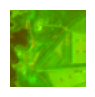

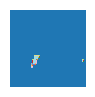

In [109]:
# Display one example of a prediction
sample_preds (preds)

In [110]:
# Save the predicted mask images (png) according to their row and column number
create_predited_mask(image_folder, learn, predicted_folder)

In [111]:
# Put together all the blocks in label_folder
merge_blocks(label_folder,'merged_labels.png', Nrows, Ncols, width, height, Nbands=1)

In [112]:
# Put together all the blocks in predicted_folder
merge_blocks(predicted_folder,'merged_predicted_labels.png', Nrows, Ncols, width, height, Nbands = 3)

**Results**

In [ ]:
# Display images, ground-truth mask and the respective predicted mask
display_images(directory, image_folder, label_folder, predicted_folder, preds)

In [ ]:
# Calculate and display images, ground-truth mask and the respective predicted mask, plus the pixel-wise error associated to each block
pixel_wise_errors(test_file_names, label_folder, predicted_folder, image_folder)

In [ ]:
# Perform inference on the test set
preds, _ = learn.get_preds(dl=dls.valid)

# Calculate the confusion matrix for the test set
true_masks_flat, predicted_masks_flat = true_and_pred_mask_to_1D_numpy(dls, preds)
conf_matrix = confusion_matrix(true_masks_flat, predicted_masks_flat)

print("Confusion Matrix for the Test Set:")
print(conf_matrix)


Confusion Matrix for the Test Set:
[[93701  1776]
 [ 1666  8649]]


In [ ]:
#Accuracy of the model
accuracy = model_accuracy(true_masks_flat, predicted_masks_flat)
print("Model Accuracy for the Test Set: {:.2f}%".format(accuracy * 100))

Model Accuracy for the Test Set: 96.75%


In [ ]:
# Calculate and print the classification report
report = classification_report(true_masks_flat, predicted_masks_flat, target_names=target_names)
print("\nClassification Report for the Test Set:")
print(report)

In [115]:
# replace pixel values from 255 to 1. Output file is a png with pixels 0 and 1
convert_values_png(pixelvalue = 255)

Image processing complete. Saved as /content/drive/MyDrive/AAA/merged_predicted_labels_converted.png


In [ ]:
display_unique_values_and_datatype(os.path.join(directory, 'merged_predicted_labels_converted.png'))

<ipython-input-96-1e5207f6686d>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  predicted_mask = predicted_mask.resize(ground_truth_mask.shape[::-1], Image.ANTIALIAS)# Resize the predicted mask to match the dimensions of the ground truth mask


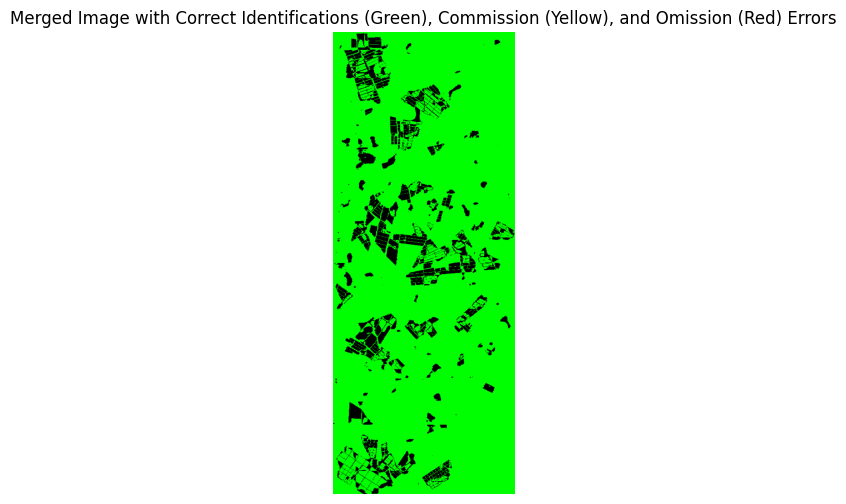

In [118]:
# Comission and Omission Errors
# Load the ground truth TIFF mask and predicted PNG mask
#with rasterio.open(os.path.join(directory, 'mask_3763_reclass_bin.tif')) as tiff_mask:
#    ground_truth_mask = tiff_mask.read(1)  # Assuming it's a one-band TIFF
ground_truth_mask = Image.open(os.path.join(directory, 'merged_labels.png'))
resized_predicted_mask = convert_and_resize_pred_mask(directory, 'resized_predicted_mask.png', 'merged_predicted_labels_converted.png')

comission_omission_erros (ground_truth_mask, resized_predicted_mask, predicted_folder, 'comission_omission.png')